<a href="https://colab.research.google.com/github/ekaterinatao/datatone_Pawfull/blob/master/Team_Pawfull.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import glob
import re
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

#from pandasql import sqldf
import warnings
warnings.simplefilter("ignore")

# Functions

In [ ]:
# пока не заполнять, в конце соберу, что возможно в функции

In [2]:
def col_year(col):
    col = re.findall(r'[0-9]+', col)[0]
    return col

In [4]:
pysqldf = lambda q: sqldf(q, globals())

# Preprocessing 
### Data cleaning 
### Dataset: Air pollution

In [3]:
# чтение файлов 
!git clone https://github.com/EugeneBaev-dsu4/pawfull.git
CO = pd.read_excel('pawfull/aqdh-country-trends-major-air-pollutants-2003-2018.xlsx', sheet_name=5)
O3 = pd.read_excel('pawfull/aqdh-country-trends-major-air-pollutants-2003-2018.xlsx', sheet_name=9)
PM = pd.read_excel('pawfull/aqdh-country-trends-major-air-pollutants-2003-2018.xlsx', sheet_name=11)

fatal: destination path 'pawfull' already exists and is not an empty directory.


In [4]:
CO.head()

,code,iso,country,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,876,WLF,Wallis and Futuna Islands,0.058569,0.056635,0.055689,0.054475,0.056712,0.052455,0.049982,0.050788,0.049598,0.050067,0.048616,0.048762,0.049999,0.048187,0.051362,0.050095
1,570,NIU,Niue,0.059838,0.058239,0.056967,0.055914,0.057780,0.053317,0.050798,0.051572,0.049778,0.051011,0.048137,0.048778,0.049933,0.048340,0.051866,0.050753
2,776,TON,Tonga,0.059927,0.058896,0.058301,0.056700,0.058044,0.053633,0.051075,0.052749,0.051293,0.051737,0.048889,0.049491,0.050606,0.049613,0.051790,0.050759
3,882,WSM,Samoa,0.060699,0.058907,0.058653,0.057342,0.059025,0.054557,0.051888,0.053584,0.051394,0.052414,0.050581,0.050653,0.052024,0.050672,0.052552,0.051334
4,184,COK,Cook Islands,0.059756,0.058554,0.057885,0.056303,0.058259,0.053418,0.050410,0.051857,0.049531,0.050904,0.047956,0.048062,0.049475,0.048105,0.052248,0.051419


##### Converting to suitable data types

In [5]:
# оставляем нужные нам столбцы
CO_2015_2018 = CO[['country', 2015, 2016, 2017, 2018]]
O3_2015_2018 = O3[['country', 2015, 2016, 2017, 2018]]
PM_2015_2018 = PM[['country', 2015, 2016, 2017, 2018]]

In [8]:
CO_2015_2018

,country,2015,2016,2017,2018
0,Wallis and Futuna Islands,0.049999,0.048187,0.051362,0.050095
1,Niue,0.049933,0.048340,0.051866,0.050753
2,Tonga,0.050606,0.049613,0.051790,0.050759
3,Samoa,0.052024,0.050672,0.052552,0.051334
4,Cook Islands,0.049475,0.048105,0.052248,0.051419
...,...,...,...,...,...
212,China,0.704168,0.688977,0.689349,0.693457
213,Bangladesh,0.693170,0.698953,0.645853,0.735738
214,Pakistan,0.724600,0.778792,0.747174,0.757198
215,India,0.728253,0.752007,0.731299,0.758780


In [6]:
CO_2015_2018 = CO_2015_2018.melt(id_vars=['country'])
CO_2015_2018 = CO_2015_2018.rename(columns={'variable': 'year', 'value': 'CO'}).sort_values(by=['country', 'year']).reset_index(drop=True)
CO_2015_2018

,country,year,CO
0,Afghanistan,2015,0.188489
1,Afghanistan,2016,0.190931
2,Afghanistan,2017,0.195364
3,Afghanistan,2018,0.183300
4,Albania,2015,0.156164
...,...,...,...
863,Zambia,2018,0.190789
864,Zimbabwe,2015,0.205553
865,Zimbabwe,2016,0.187814
866,Zimbabwe,2017,0.189745


In [7]:
O3_2015_2018 = O3_2015_2018.melt(id_vars=['country'])
O3_2015_2018 = O3_2015_2018.rename(columns={'variable': 'year', 'value': 'O3'}).sort_values(by=['country', 'year']).reset_index(drop=True)
O3_2015_2018

,country,year,O3
0,Afghanistan,2015,0.057616
1,Afghanistan,2016,0.057530
2,Afghanistan,2017,0.058393
3,Afghanistan,2018,0.059366
4,Albania,2015,0.058433
...,...,...,...
863,Zambia,2018,0.044849
864,Zimbabwe,2015,0.045374
865,Zimbabwe,2016,0.044779
866,Zimbabwe,2017,0.043821


In [8]:
PM_2015_2018 = PM_2015_2018.melt(id_vars=['country'])
PM_2015_2018 = PM_2015_2018.rename(columns={'variable': 'year', 'value': 'PM'}).sort_values(by=['country', 'year']).reset_index(drop=True)
PM_2015_2018

,country,year,PM
0,Afghanistan,2015,2.037780e-08
1,Afghanistan,2016,2.067060e-08
2,Afghanistan,2017,2.057590e-08
3,Afghanistan,2018,2.794360e-08
4,Albania,2015,1.148180e-08
...,...,...,...
863,Zambia,2018,1.898560e-08
864,Zimbabwe,2015,1.797930e-08
865,Zimbabwe,2016,1.586790e-08
866,Zimbabwe,2017,1.630900e-08


##### Outliers detection

Построим box-plots для визуального определения выбросов

In [ ]:
#CO_2015_2018.describe()

In [ ]:
#O3_2015_2018.describe()

In [ ]:
#PM_2015_2018.describe()

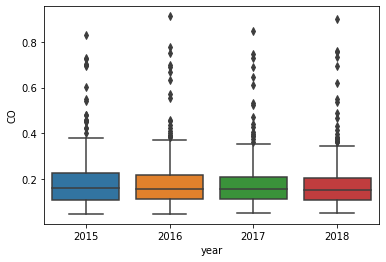

In [14]:
sns.boxplot(data=CO_2015_2018, y='CO', x='year')

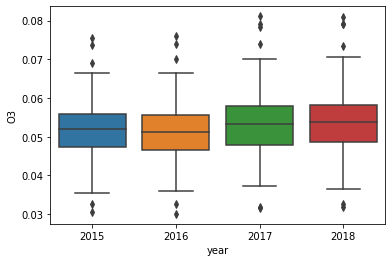

In [15]:
sns.boxplot(data=O3_2015_2018, y='O3', x='year')

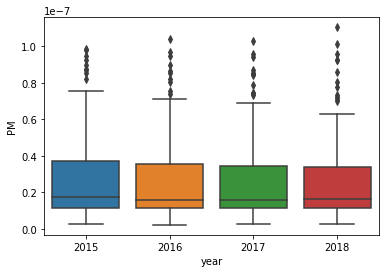

In [16]:
sns.boxplot(data=PM_2015_2018, y='PM', x='year')

Можно сказать, что выбросы присутствую по каждому показтелю, хотя это только условно можно считать выбросами, это же раельные показатели в отдельных странах с высоким загрязнением и довольно любопытно как это коррелирует с другими показателями (здоровья, респираторной заболеваемостью, показателями счастья)

##### Duplicate and missing data

In [9]:
# посмотрим на пропуски в данных
dfs = {'CO_2015_2018': CO_2015_2018, 'O3_2015_2018': O3_2015_2018, 'PM_2015_2018': PM_2015_2018}

for name, df in dfs.items():
  print(f' В {name} = {sum(df.isnull().sum())} пропусков')

 В CO_2015_2018 = 0 пропусков
 В O3_2015_2018 = 0 пропусков
 В PM_2015_2018 = 0 пропусков


In [10]:
# посмотрим на дубликаты в данных
for name, df in dfs.items():
  print(f' В {name} = {df.duplicated().sum()} дубликатов')

 В CO_2015_2018 = 0 дубликатов
 В O3_2015_2018 = 0 дубликатов
 В PM_2015_2018 = 0 дубликатов


##### Feature engeneering

In [11]:
# добавим столбец по среднему показателю за 4 года
CO_2015_2018['CO_mean'] = CO_2015_2018.groupby('country')['CO'].transform('mean')
O3_2015_2018['O3_mean'] = O3_2015_2018.groupby('country')['O3'].transform('mean')
PM_2015_2018['PM_mean'] = PM_2015_2018.groupby('country')['PM'].transform('mean')

In [12]:
# добавим столбец по изменению показателя за 4 года
#CO_2015_2018['uplift_CO'] = CO_2015_2018[2018] - CO_2015_2018[2015]
#O3_2015_2018['uplift_O3'] = O3_2015_2018[2018] - O3_2015_2018[2015]
#PM_2015_2018['uplift_PM'] = PM_2015_2018[2018] - PM_2015_2018[2015]
CO_2015_2018['uplift_CO'] = CO_2015_2018.groupby('country')['CO'].diff()
O3_2015_2018['uplift_O3'] = O3_2015_2018.groupby('country')['O3'].diff()
PM_2015_2018['uplift_PM'] = PM_2015_2018.groupby('country')['PM'].diff()

In [13]:
O3_2015_2018

,country,year,O3,O3_mean,uplift_O3
0,Afghanistan,2015,0.057616,0.058226,NaN
1,Afghanistan,2016,0.057530,0.058226,-0.000087
2,Afghanistan,2017,0.058393,0.058226,0.000864
3,Afghanistan,2018,0.059366,0.058226,0.000973
4,Albania,2015,0.058433,0.059796,NaN
...,...,...,...,...,...
863,Zambia,2018,0.044849,0.045010,0.000015
864,Zimbabwe,2015,0.045374,0.044924,NaN
865,Zimbabwe,2016,0.044779,0.044924,-0.000594
866,Zimbabwe,2017,0.043821,0.044924,-0.000958


In [14]:
# сделаем общую таблицу с показателями загрязнений за 2015-2018 года
df_2015_2018 = CO_2015_2018.merge(O3_2015_2018, on=['country', 'year'])
df_pollution_2015_2018 = df_2015_2018.merge(PM_2015_2018, on=['country', 'year'])
df_pollution_2015_2018.head()

,country,year,CO,CO_mean,uplift_CO,O3,O3_mean,uplift_O3,PM,PM_mean,uplift_PM
0,Afghanistan,2015,0.188489,0.189521,NaN,0.057616,0.058226,NaN,2.037780e-08,2.239198e-08,NaN
1,Afghanistan,2016,0.190931,0.189521,0.002441,0.057530,0.058226,-0.000087,2.067060e-08,2.239198e-08,2.928000e-10
2,Afghanistan,2017,0.195364,0.189521,0.004433,0.058393,0.058226,0.000864,2.057590e-08,2.239198e-08,-9.470000e-11
3,Afghanistan,2018,0.183300,0.189521,-0.012064,0.059366,0.058226,0.000973,2.794360e-08,2.239198e-08,7.367700e-09
4,Albania,2015,0.156164,0.146900,NaN,0.058433,0.059796,NaN,1.148180e-08,1.181145e-08,NaN


### Dataset: Mortality

In [15]:
!git clone https://github.com/EugeneBaev-dsu4/pawfull.git
respiratory = pd.read_csv('pawfull/respiratory-disease-death-rate.csv')

fatal: destination path 'pawfull' already exists and is not an empty directory.


In [16]:
respiratory.rename(columns = {'Deaths - Chronic respiratory diseases - Sex: Both - Age: Age-standardized (Rate)': 'ROD Resp', 'Entity': "country",
                              'Year': 'year'}, inplace = True)
respiratory

,country,Code,year,ROD Resp
0,Afghanistan,AFG,1990,94.84
1,Afghanistan,AFG,1991,94.36
2,Afghanistan,AFG,1992,94.06
3,Afghanistan,AFG,1993,94.85
4,Afghanistan,AFG,1994,96.23
...,...,...,...,...
6835,Zimbabwe,ZWE,2015,51.63
6836,Zimbabwe,ZWE,2016,51.02
6837,Zimbabwe,ZWE,2017,50.32
6838,Zimbabwe,ZWE,2018,49.63


##### Converting to suitable data types

In [18]:
# оставляем нужные нам диапазон лет
respiratory = respiratory[(respiratory['year'] >= 2015) & (respiratory['year'] <= 2018)].reset_index(drop=True)
respiratory

,country,Code,year,ROD Resp
0,Afghanistan,AFG,2015,72.11
1,Afghanistan,AFG,2016,70.90
2,Afghanistan,AFG,2017,69.95
3,Afghanistan,AFG,2018,68.95
4,African Region (WHO),NaN,2015,46.36
...,...,...,...,...
907,Zambia,ZMB,2018,42.36
908,Zimbabwe,ZWE,2015,51.63
909,Zimbabwe,ZWE,2016,51.02
910,Zimbabwe,ZWE,2017,50.32


##### Duplicate and missing data

In [48]:
respiratory.duplicated().sum()

0

In [49]:
respiratory.isna().sum()

country      0
Code        92
Year         0
ROD Resp     0
dtype: int64

##### Feature engeneering

In [19]:
respiratory['Increase Resp'] = respiratory.groupby('country')['ROD Resp'].diff()
respiratory

,country,Code,year,ROD Resp,Increase Resp
0,Afghanistan,AFG,2015,72.11,NaN
1,Afghanistan,AFG,2016,70.90,-1.21
2,Afghanistan,AFG,2017,69.95,-0.95
3,Afghanistan,AFG,2018,68.95,-1.00
4,African Region (WHO),NaN,2015,46.36,NaN
...,...,...,...,...,...
907,Zambia,ZMB,2018,42.36,-0.70
908,Zimbabwe,ZWE,2015,51.63,NaN
909,Zimbabwe,ZWE,2016,51.02,-0.61
910,Zimbabwe,ZWE,2017,50.32,-0.70


### Dstaset: Smoking

In [20]:
!git clone https://github.com/ekaterinatao/datatone_Pawfull
smoking = pd.read_csv('datatone_Pawfull/data/share-of-adults-who-smoke.csv')
smoking.head()

fatal: destination path 'datatone_Pawfull' already exists and is not an empty directory.


,Entity,Code,Year,Prevalence of current tobacco use (% of adults)
0,Afghanistan,AFG,2000,36.900002
1,Afghanistan,AFG,2005,32.700001
2,Afghanistan,AFG,2010,29.100000
3,Afghanistan,AFG,2015,26.000000
4,Afghanistan,AFG,2018,23.799999


In [21]:
smoking.rename(columns = {'Prevalence of current tobacco use (% of adults)': 'ROD Smoke', 'Entity': "country",
                          'Year': 'year'}, inplace = True)
smoking

,country,Code,year,ROD Smoke
0,Afghanistan,AFG,2000,36.900002
1,Afghanistan,AFG,2005,32.700001
2,Afghanistan,AFG,2010,29.100000
3,Afghanistan,AFG,2015,26.000000
4,Afghanistan,AFG,2018,23.799999
...,...,...,...,...
1241,Zimbabwe,ZWE,2010,15.600000
1242,Zimbabwe,ZWE,2015,13.600000
1243,Zimbabwe,ZWE,2018,12.100000
1244,Zimbabwe,ZWE,2019,12.100000


In [22]:
# оставляем нужные нам диапазон лет
smoking = smoking[(smoking['year'] >= 2015) & (smoking['year'] <= 2018)].reset_index(drop=True)
smoking

,country,Code,year,ROD Smoke
0,Afghanistan,AFG,2015,26.000000
1,Afghanistan,AFG,2018,23.799999
2,Albania,ALB,2015,25.100000
3,Albania,ALB,2018,23.000000
4,Algeria,DZA,2015,21.100000
...,...,...,...,...
351,Yemen,YEM,2018,20.500000
352,Zambia,ZMB,2015,15.500000
353,Zambia,ZMB,2018,14.600000
354,Zimbabwe,ZWE,2015,13.600000


In [23]:
#Resp increase - прирост смертности, smoke increase - прирост куращих

smoking['Increase Smoke'] = smoking.groupby('country')['ROD Smoke'].diff()
smoking

,country,Code,year,ROD Smoke,Increase Smoke
0,Afghanistan,AFG,2015,26.000000,NaN
1,Afghanistan,AFG,2018,23.799999,-2.200001
2,Albania,ALB,2015,25.100000,NaN
3,Albania,ALB,2018,23.000000,-2.100000
4,Algeria,DZA,2015,21.100000,NaN
...,...,...,...,...,...
351,Yemen,YEM,2018,20.500000,-1.299999
352,Zambia,ZMB,2015,15.500000,NaN
353,Zambia,ZMB,2018,14.600000,-0.900000
354,Zimbabwe,ZWE,2015,13.600000,NaN


##### Converting to suitable data types

##### Outliers detection

##### Duplicate and missing data

### Dataset: Happiness

In [24]:
!git clone https://github.com/EugeneBaev-dsu4/pawfull.git
happiness = pd.concat(
    [pd.read_csv(i).assign(year= i) for i in glob.glob('pawfull/happiness_201[5678]*')], 
    axis=0
)
happiness = happiness.reset_index(drop=True)
happiness['year'] = happiness['year'].apply(col_year).astype(int)
happiness.head()

fatal: destination path 'pawfull' already exists and is not an empty directory.


,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,...,Trust..Government.Corruption.,Dystopia.Residual,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Perceptions of corruption
0,Denmark,Western Europe,1.0,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Switzerland,Western Europe,2.0,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Iceland,Western Europe,3.0,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Norway,Western Europe,4.0,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Finland,Western Europe,5.0,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
happiness.columns

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Lower Confidence Interval', 'Upper Confidence Interval',
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity',
       'Dystopia Residual', 'year', 'Standard Error', 'Happiness.Rank',
       'Happiness.Score', 'Whisker.high', 'Whisker.low',
       'Economy..GDP.per.Capita.', 'Health..Life.Expectancy.',
       'Trust..Government.Corruption.', 'Dystopia.Residual', 'Overall rank',
       'Country or region', 'Score', 'GDP per capita', 'Social support',
       'Healthy life expectancy', 'Freedom to make life choices',
       'Perceptions of corruption'],
      dtype='object')

In [25]:
# В сете колонки с одинаковыми по смыслу данными, но в колонках с разным  названием, соберем в одно целое...
happiness['Country'] = happiness['Country'].combine_first(happiness['Country or region'])
happiness['Economy (GDP per Capita)'] = happiness['Economy (GDP per Capita)'].combine_first(happiness['GDP per capita'])
happiness['Economy (GDP per Capita)'] = happiness['Economy (GDP per Capita)'].combine_first(happiness['Economy..GDP.per.Capita.'])
happiness['Health (Life Expectancy)']= happiness['Health (Life Expectancy)'].combine_first(happiness['Healthy life expectancy'])
happiness['Health (Life Expectancy)']= happiness['Health (Life Expectancy)'].combine_first(happiness['Health..Life.Expectancy.'])
happiness['Trust (Government Corruption)'] = happiness['Trust (Government Corruption)'].combine_first(happiness['Perceptions of corruption'])
happiness['Trust (Government Corruption)'] = happiness['Trust (Government Corruption)'].combine_first(happiness['Trust..Government.Corruption.'])
happiness['Freedom'] = happiness['Freedom'].combine_first(happiness['Freedom to make life choices'])
happiness['Happiness Rank'] = happiness['Happiness Rank'].combine_first(happiness['Happiness.Rank'])
happiness['Happiness Score'] = happiness['Happiness Score'].combine_first(happiness['Happiness.Score'])
happiness['Lower Confidence Interval'] = happiness['Lower Confidence Interval'].combine_first(happiness['Whisker.low'])
happiness['Upper Confidence Interval'] = happiness['Upper Confidence Interval'].combine_first(happiness['Whisker.high'])
happiness['Dystopia Residual'] = happiness['Dystopia Residual'].combine_first(happiness['Dystopia.Residual'])

In [26]:
# уберем ставшими ненужными колонки
happiness.drop(columns=['Country or region', 'GDP per capita','Economy..GDP.per.Capita.','Healthy life expectancy','Healthy life expectancy','Health..Life.Expectancy.','Perceptions of corruption','Trust..Government.Corruption.','Freedom to make life choices','Happiness Rank','Happiness.Rank','Happiness.Score','Whisker.low','Whisker.high','Dystopia.Residual'], inplace=True)

In [ ]:
happiness


In [55]:
# Здесь убирались дубликаты стран, без этой строчки их как раз будет по количесттву датасетов.
#happiness.drop_duplicates(subset=['Country'], keep='first',inplace=True)

In [27]:
happiness.reset_index()

,index,Country,Region,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,year,Standard Error,Overall rank,Score,Social support
0,0,Denmark,Western Europe,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939,2016,NaN,NaN,NaN,NaN
1,1,Switzerland,Western Europe,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463,2016,NaN,NaN,NaN,NaN
2,2,Iceland,Western Europe,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137,2016,NaN,NaN,NaN,NaN
3,3,Norway,Western Europe,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465,2016,NaN,NaN,NaN,NaN
4,4,Finland,Western Europe,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596,2016,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,621,Yemen,NaN,NaN,NaN,NaN,0.44200,NaN,0.34300,0.24400,0.06400,0.08300,NaN,2018,NaN,152.0,3.355,1.073
622,622,Tanzania,NaN,NaN,NaN,NaN,0.45500,NaN,0.38100,0.48100,0.09700,0.27000,NaN,2018,NaN,153.0,3.303,0.991
623,623,South Sudan,NaN,NaN,NaN,NaN,0.33700,NaN,0.17700,0.11200,0.10600,0.22400,NaN,2018,NaN,154.0,3.254,0.608
624,624,Central African Republic,NaN,NaN,NaN,NaN,0.02400,NaN,0.01000,0.30500,0.03800,0.21800,NaN,2018,NaN,155.0,3.083,0.000


In [ ]:
happiness.columns

Index(['Country', 'Region', 'Happiness Score', 'Lower Confidence Interval',
       'Upper Confidence Interval', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual', 'year', 'Standard Error',
       'Overall rank', 'Score', 'Social support'],
      dtype='object')

In [28]:
# Убираем неинформативные признаки:
happiness = happiness.drop(columns=['Standard Error','Overall rank','Score','Social support', 'Lower Confidence Interval', 'Upper Confidence Interval'])

In [29]:
# переводи в категоральный вид страны и регионы (нужно ли?)
happiness[['Country','Region']]=happiness[['Country','Region']].astype("category")
happiness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Country                        626 non-null    category
 1   Region                         315 non-null    category
 2   Happiness Score                470 non-null    float64 
 3   Economy (GDP per Capita)       626 non-null    float64 
 4   Family                         470 non-null    float64 
 5   Health (Life Expectancy)       626 non-null    float64 
 6   Freedom                        626 non-null    float64 
 7   Trust (Government Corruption)  625 non-null    float64 
 8   Generosity                     626 non-null    float64 
 9   Dystopia Residual              470 non-null    float64 
 10  year                           626 non-null    int64   
dtypes: category(2), float64(8), int64(1)
memory usage: 51.7 KB


In [30]:
happiness

,Country,Region,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,year
0,Denmark,Western Europe,7.526,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939,2016
1,Switzerland,Western Europe,7.509,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463,2016
2,Iceland,Western Europe,7.501,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137,2016
3,Norway,Western Europe,7.498,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465,2016
4,Finland,Western Europe,7.413,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596,2016
...,...,...,...,...,...,...,...,...,...,...,...
621,Yemen,NaN,NaN,0.44200,NaN,0.34300,0.24400,0.06400,0.08300,NaN,2018
622,Tanzania,NaN,NaN,0.45500,NaN,0.38100,0.48100,0.09700,0.27000,NaN,2018
623,South Sudan,NaN,NaN,0.33700,NaN,0.17700,0.11200,0.10600,0.22400,NaN,2018
624,Central African Republic,NaN,NaN,0.02400,NaN,0.01000,0.30500,0.03800,0.21800,NaN,2018


### Converting to suitable data types

In [31]:
happiness.rename(columns = {'Country': 'country'}, inplace = True)
happiness

,country,Region,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,year
0,Denmark,Western Europe,7.526,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939,2016
1,Switzerland,Western Europe,7.509,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463,2016
2,Iceland,Western Europe,7.501,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137,2016
3,Norway,Western Europe,7.498,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465,2016
4,Finland,Western Europe,7.413,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596,2016
...,...,...,...,...,...,...,...,...,...,...,...
621,Yemen,NaN,NaN,0.44200,NaN,0.34300,0.24400,0.06400,0.08300,NaN,2018
622,Tanzania,NaN,NaN,0.45500,NaN,0.38100,0.48100,0.09700,0.27000,NaN,2018
623,South Sudan,NaN,NaN,0.33700,NaN,0.17700,0.11200,0.10600,0.22400,NaN,2018
624,Central African Republic,NaN,NaN,0.02400,NaN,0.01000,0.30500,0.03800,0.21800,NaN,2018


### Outliers detection

### Duplicate and missing data

In [60]:
happiness.isna().sum()

Country                          0
Region                           4
Happiness Score                  2
Lower Confidence Interval        9
Upper Confidence Interval        9
Economy (GDP per Capita)         0
Family                           2
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                2
year                             0
dtype: int64

In [61]:
happiness.duplicated().sum()

0

### Merging datasets

In [32]:
resp_smoke = respiratory.merge(smoking, how='left', on=['country', 'year'])
resp_smoke

,country,Code_x,year,ROD Resp,Increase Resp,Code_y,ROD Smoke,Increase Smoke
0,Afghanistan,AFG,2015,72.11,NaN,AFG,26.000000,NaN
1,Afghanistan,AFG,2016,70.90,-1.21,NaN,NaN,NaN
2,Afghanistan,AFG,2017,69.95,-0.95,NaN,NaN,NaN
3,Afghanistan,AFG,2018,68.95,-1.00,AFG,23.799999,-2.200001
4,African Region (WHO),NaN,2015,46.36,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
907,Zambia,ZMB,2018,42.36,-0.70,ZMB,14.600000,-0.900000
908,Zimbabwe,ZWE,2015,51.63,NaN,ZWE,13.600000,NaN
909,Zimbabwe,ZWE,2016,51.02,-0.61,NaN,NaN,NaN
910,Zimbabwe,ZWE,2017,50.32,-0.70,NaN,NaN,NaN


In [34]:
resp_smoke_poll = resp_smoke.merge(df_pollution_2015_2018, how='left', on=['country', 'year'])
resp_smoke_poll


,country,Code_x,year,ROD Resp,Increase Resp,Code_y,ROD Smoke,Increase Smoke,CO,CO_mean,uplift_CO,O3,O3_mean,uplift_O3,PM,PM_mean,uplift_PM
0,Afghanistan,AFG,2015,72.11,NaN,AFG,26.000000,NaN,0.188489,0.189521,NaN,0.057616,0.058226,NaN,2.037780e-08,2.239198e-08,NaN
1,Afghanistan,AFG,2016,70.90,-1.21,NaN,NaN,NaN,0.190931,0.189521,0.002441,0.057530,0.058226,-0.000087,2.067060e-08,2.239198e-08,2.928000e-10
2,Afghanistan,AFG,2017,69.95,-0.95,NaN,NaN,NaN,0.195364,0.189521,0.004433,0.058393,0.058226,0.000864,2.057590e-08,2.239198e-08,-9.470000e-11
3,Afghanistan,AFG,2018,68.95,-1.00,AFG,23.799999,-2.200001,0.183300,0.189521,-0.012064,0.059366,0.058226,0.000973,2.794360e-08,2.239198e-08,7.367700e-09
4,African Region (WHO),NaN,2015,46.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,Zambia,ZMB,2018,42.36,-0.70,ZMB,14.600000,-0.900000,0.190789,0.197839,0.006711,0.044849,0.045010,0.000015,1.898560e-08,2.032793e-08,-2.500000e-12
908,Zimbabwe,ZWE,2015,51.63,NaN,ZWE,13.600000,NaN,0.205553,0.192544,NaN,0.045374,0.044924,NaN,1.797930e-08,1.644463e-08,NaN
909,Zimbabwe,ZWE,2016,51.02,-0.61,NaN,NaN,NaN,0.187814,0.192544,-0.017739,0.044779,0.044924,-0.000594,1.586790e-08,1.644463e-08,-2.111400e-09
910,Zimbabwe,ZWE,2017,50.32,-0.70,NaN,NaN,NaN,0.189745,0.192544,0.001930,0.043821,0.044924,-0.000958,1.630900e-08,1.644463e-08,4.411000e-10


In [35]:
df_final = resp_smoke_poll.merge(happiness, how='left', on=['country', 'year'])
df_final

,country,Code_x,year,ROD Resp,Increase Resp,Code_y,ROD Smoke,Increase Smoke,CO,CO_mean,...,uplift_PM,Region,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Afghanistan,AFG,2015,72.11,NaN,AFG,26.000000,NaN,0.188489,0.189521,...,NaN,Southern Asia,3.575,0.319820,0.302850,0.303350,0.234140,0.097190,0.365100,1.952100
1,Afghanistan,AFG,2016,70.90,-1.21,NaN,NaN,NaN,0.190931,0.189521,...,2.928000e-10,Southern Asia,3.360,0.382270,0.110370,0.173440,0.164300,0.071120,0.312680,2.145580
2,Afghanistan,AFG,2017,69.95,-0.95,NaN,NaN,NaN,0.195364,0.189521,...,-9.470000e-11,NaN,3.794,0.401477,0.581543,0.180747,0.106180,0.061158,0.311871,2.150801
3,Afghanistan,AFG,2018,68.95,-1.00,AFG,23.799999,-2.200001,0.183300,0.189521,...,7.367700e-09,NaN,NaN,0.332000,NaN,0.255000,0.085000,0.036000,0.191000,NaN
4,African Region (WHO),NaN,2015,46.36,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,Zambia,ZMB,2018,42.36,-0.70,ZMB,14.600000,-0.900000,0.190789,0.197839,...,-2.500000e-12,NaN,NaN,0.562000,NaN,0.295000,0.503000,0.082000,0.221000,NaN
908,Zimbabwe,ZWE,2015,51.63,NaN,ZWE,13.600000,NaN,0.205553,0.192544,...,NaN,Sub-Saharan Africa,4.610,0.271000,1.032760,0.334750,0.258610,0.080790,0.189870,2.441910
909,Zimbabwe,ZWE,2016,51.02,-0.61,NaN,NaN,NaN,0.187814,0.192544,...,-2.111400e-09,Sub-Saharan Africa,4.193,0.350410,0.714780,0.159500,0.254290,0.085820,0.185030,2.442700
910,Zimbabwe,ZWE,2017,50.32,-0.70,NaN,NaN,NaN,0.189745,0.192544,...,4.411000e-10,NaN,3.875,0.375847,1.083096,0.196764,0.336384,0.095375,0.189143,1.597970


# EDA
### Feature engineering

In [36]:
# итоговый объединенный датасет
df_final.head()

,country,Code_x,year,ROD Resp,Increase Resp,Code_y,ROD Smoke,Increase Smoke,CO,CO_mean,...,uplift_PM,Region,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Afghanistan,AFG,2015,72.11,NaN,AFG,26.000000,NaN,0.188489,0.189521,...,NaN,Southern Asia,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,0.365100,1.952100
1,Afghanistan,AFG,2016,70.90,-1.21,NaN,NaN,NaN,0.190931,0.189521,...,2.928000e-10,Southern Asia,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,0.312680,2.145580
2,Afghanistan,AFG,2017,69.95,-0.95,NaN,NaN,NaN,0.195364,0.189521,...,-9.470000e-11,NaN,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,0.311871,2.150801
3,Afghanistan,AFG,2018,68.95,-1.00,AFG,23.799999,-2.200001,0.183300,0.189521,...,7.367700e-09,NaN,NaN,0.332000,NaN,0.255000,0.08500,0.036000,0.191000,NaN
4,African Region (WHO),NaN,2015,46.36,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Descriptive statistics

### Hypothesis testing

### Check multicollinearity

### Feature selection

### Feature encoding

# Model building

In [ ]:
# можно выбрать любые модели